Divisive suppression explains high-precision firing and contrast adaptation in retinal ganglion cells <br>
url = {https://dx.doi.org/10.7554/elife.19460}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage
from scipy.io import loadmat
from scipy.optimize import curve_fit
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def NGD_TK_AS(T, epsilon, omegastar, deltastar, tau_y, Bmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kt = -Bmp/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar)
    return np.convolve(x, Kt, 'full')[:len(T):50]

In [3]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# Load Data

In [31]:
dt = 0.01
cn = 19

file_list = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=0.5_20-Jul-2021_0',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=1_20-Jul-2021_0',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=1.5_20-Jul-2021_0',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=2_20-Jul-2021_0',
             'D:\\GoogleDrive\\retina\\Chou\'s data\\20210720\\WF\\data\\diode_WhiteNoise_mean=10_amp=3_20-Jul-2021_0']
contrast_list = [5, 10, 15, 20, 30]
x_list = []
T_list = []
rstate_list = []
for file in file_list:
    annots = loadmat(file, squeeze_me = True)
    sampling_rate = 20000
    TimeStamps = annots['TimeStamps']
    x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
    x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/5), mode='reflect') / dt
    x = x[::int(sampling_rate*dt)]
    x = x.astype(float)
    # print(np.std(x)/4E4)
    x = (x -np.mean(x))/np.std(x)
    T = np.arange(len(x)+1)*dt
    rstate,_ = np.histogram(annots['Spikes'][cn-1]-TimeStamps[0], T)
    rstate_list.append( rstate.copy() )
    x_list.append( x.copy() )
    T_list.append( T.copy() )

In [5]:
for i in range(len(x_list)):
    print(sum(rstate_list[i])/contrast_list[i])


81.0
89.0
79.93333333333334
59.45
46.666666666666664


(0.0, 1.0)

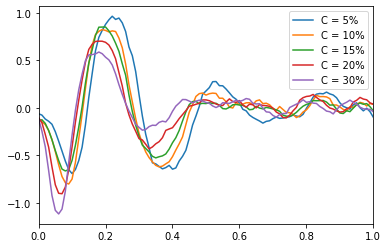

In [6]:
TKaxis = np.arange(101)*dt
TK_list = []
for i in range(len(x_list)):
    rstate = rstate_list[i]
    x = x_list[i]
    x = (x -np.mean(x))/np.std(x)
    TK = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
    TK = TK[int(len(TK)/2):int(len(TK)/2-1/dt)-1:-1]
    plt.plot(TKaxis, TK, label = 'C = '+str(contrast_list[i])+'%')
    TK_list.append( TK.copy() )
plt.legend(loc = 'best')
plt.xlim(0, 1)

# Fit

(0.0, 1.0)

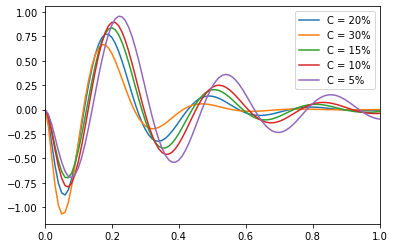

In [7]:
name_list  = ['epsilon', 'omegastar', 'deltastar', 'tau_y', 'Bmp' ]
initials   = [5        , 20         , 0.         , 0.03   , 2     ]
ibounds_min = [0        , 0          , -np.pi     , 0      , 0     ]
ibounds_max = [np.inf   , np.inf     ,  np.pi     , 0.5    , np.inf]

para_2dlist = [0]*len(x_list)
fitTK_list = [0]*len(x_list)

bounds_min = ibounds_min.copy()
bounds_max = ibounds_max.copy()
for i in [3,4,2,1,0]:
# for i in range(len(x_list)):
    popt,_ = curve_fit(NGD_TK_AS, TKaxis , TK_list[i], p0= initials, bounds = (bounds_min,bounds_max) )
    initials = popt
    # bounds_min = popt-1E-7
    # bounds_max = popt+1E-7
    # # chose which parameters to free
    # for j in [0,1,2,3]:
    #     bounds_min[j] = ibounds_min[j]
    #     bounds_max[j] = ibounds_max[j]
    fitTK = NGD_TK_AS(TKaxis, *popt)
    plt.plot(TKaxis, fitTK, label = 'C = '+str(contrast_list[i])+'%')
    fitTK_list[i] = fitTK.copy() 
    para_2dlist[i] = popt.copy()
plt.legend(loc = 'best')
plt.xlim(0, 1)

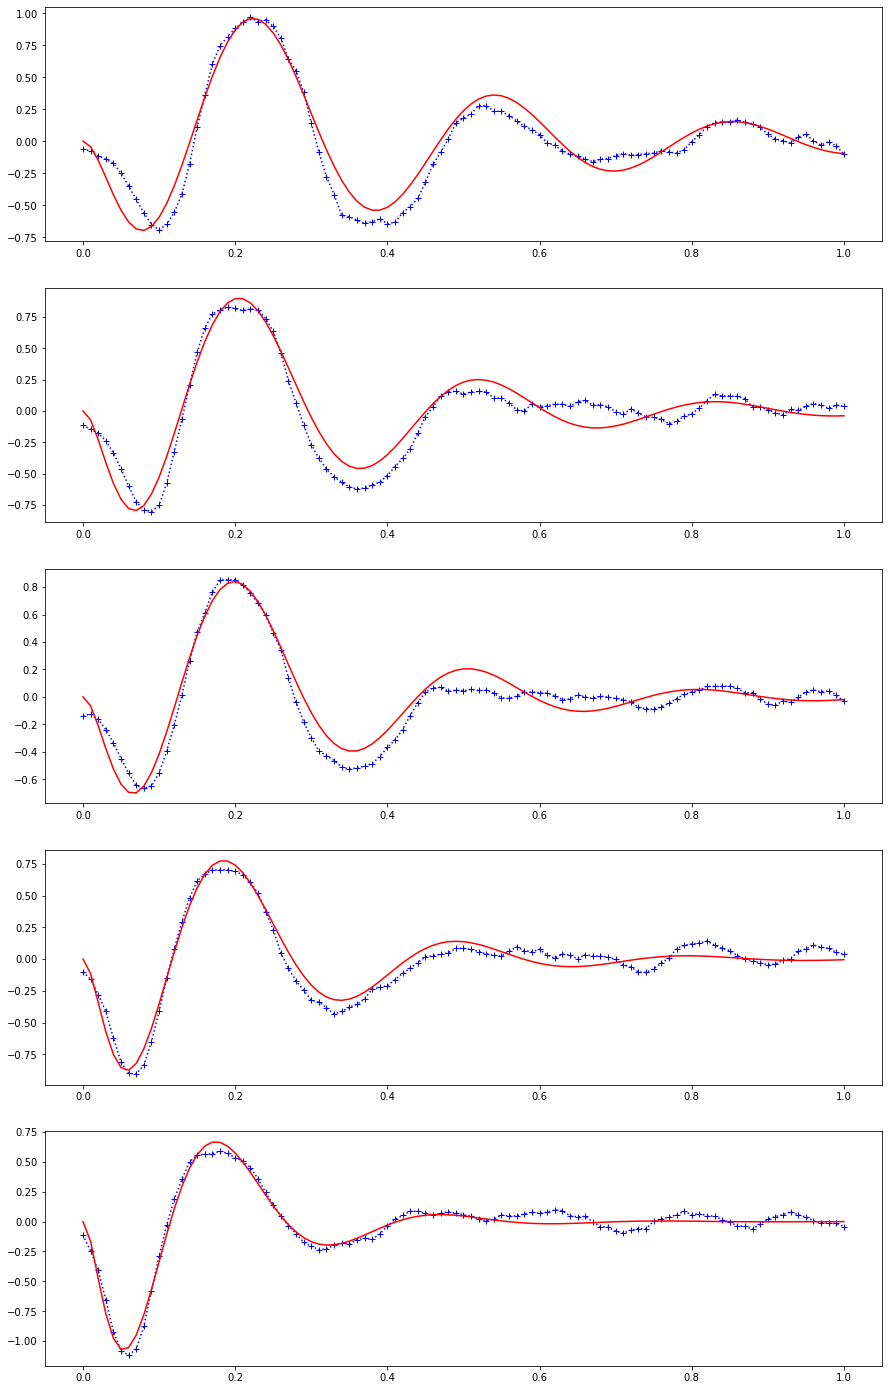

In [8]:
fig, ax = plt.subplots(len(x_list),1)
for i in range(len(x_list)):
    ax[i].plot(TKaxis, TK_list[i], 'b+:')
    ax[i].plot(TKaxis, fitTK_list[i], 'r-')
    # ax[i][1].plot(faxis, delta)
fig.set_size_inches( 15, 5*len(x_list) )

In [9]:
ASpara_DF = pd.DataFrame(para_2dlist, index = contrast_list, columns = name_list)
ASpara_DF

,epsilon,omegastar,deltastar,tau_y,Bmp
5,2.739047,20.088066,0.242166,0.054134,2.956640
10,3.921453,20.166848,0.226265,0.038097,2.503043
15,4.379838,20.755230,0.293818,0.039682,2.499848
20,5.568762,20.698866,0.208223,0.027671,2.264233
30,8.201447,21.479090,0.161868,0.024555,2.677589


In [10]:
DEpara_DF = pd.DataFrame(np.ones((len(contrast_list), 6)), index = contrast_list, columns = ['m', 'n', 'alpha', 'beta', 'g', 'tau_y'])
DEpara_DF['m'] = ASpara_DF['Bmp']
DEpara_DF['tau_y'] = ASpara_DF['tau_y']
DEpara_DF['alpha'] = ASpara_DF['epsilon']+np.tan(ASpara_DF['deltastar'])*ASpara_DF['omegastar']
DEpara_DF['beta'] = ASpara_DF['epsilon']*2-DEpara_DF['alpha']
DEpara_DF['g'] = ASpara_DF['omegastar']**2+((DEpara_DF['alpha']-DEpara_DF['beta'])**2)/4

In [28]:
DEpara_DF

,m,n,alpha,beta,g,tau_y
5,2.956640,1.0,7.701067,-2.222974,428.152020,0.054134
10,2.503043,1.0,8.563993,-0.721086,428.254942,0.038097
15,2.499848,1.0,10.659864,-1.900188,470.218314,0.039682
20,2.264233,1.0,9.942121,1.195404,447.569320,0.027671
30,2.677589,1.0,11.708909,4.693985,473.653606,0.024555


In [30]:
DEpara_DF.loc[30].values

array([2.67758918e+00, 1.00000000e+00, 1.17089092e+01, 4.69398540e+00,
       4.73653606e+02, 2.45547756e-02])

# k_E and k_S

In [12]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    n = np.sqrt(g)
    g = np.sqrt(g)
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

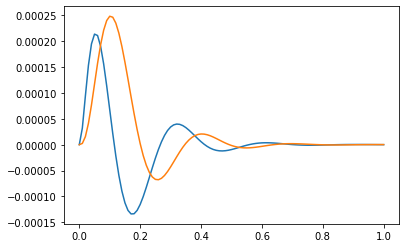

In [13]:
y_TK, w_TK = NGD_TK(TKaxis, *DEpara_DF.loc[30].values)
plt.plot(TKaxis, y_TK)
plt.plot(TKaxis, w_TK)

In [14]:
k_E = y_TK
k_S = w_TK

# LPOU input

In [15]:
dt = 0.01
tot = 1000
Taxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(Taxis))
mu, sigma = 0, 1
for i in range(len(Taxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

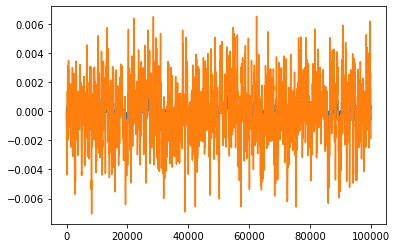

In [16]:
eOutput = np.convolve(x, k_E, 'full')[:len(x)]
sOutput = np.convolve(x, k_S, 'full')[:len(x)]

plt.plot(eOutput)
plt.plot(sOutput)

In [17]:
def f_E(input, boundary):
    if min(input) < -boundary or max(input) > boundary:
        return -1
    return (input+boundary)/(2*boundary)
def f_S(input, boundary):
    if min(input) < -boundary or max(input) > boundary:
        return -1
    p_input = (input+np.abs(input))/2
    p_input = (p_input)/boundary*2
    n_input = (input-np.abs(input))/2
    n_input = (n_input)/boundary*2

    p_output = 1/(1+p_input**1.5)
    n_output = 1/(1+np.abs(n_input)**4)
    return p_output+n_output-1

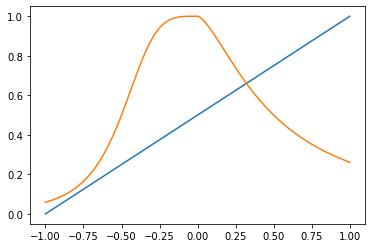

In [18]:
axis = np.linspace(-1,1,1000)
plt.plot(axis, f_E(axis, 1))
plt.plot(axis, f_S(axis, 1))

In [19]:
Output = f_E(eOutput, max(np.abs(eOutput)))*f_S(sOutput, max(np.abs(sOutput)))

(45000.0, 55000.0)

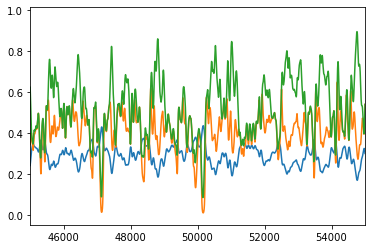

In [20]:
plt.plot(-x*0.05+0.3)
plt.plot(Output)
plt.plot(f_E(eOutput, max(np.abs(eOutput))))
plt.xlim(45000, 55000)

(45000.0, 55000.0)

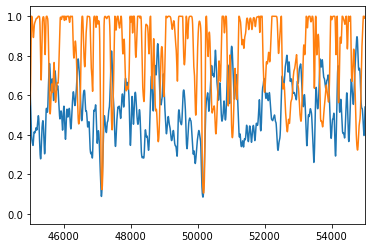

In [21]:
plt.plot(f_E(eOutput, max(np.abs(eOutput))))
plt.plot(f_S(sOutput, max(np.abs(sOutput))))
plt.xlim(45000, 55000)

# MI

In [22]:
import import_ipynb
try:
    os.chdir('Modules')
except:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from time_shifted_PID import MIfunc
# from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
# from StimulusnResponse import SSG
from Spike_Generation import SG
# from Spike_Generation import NL

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [23]:
window = [-1,1]
state_num = 6
xstate = EqualState(LPOU, state_num)[0]

rstate = SG(eOutput, dt, 0, 2, 10)
timeshift, baseMI = MIfunc(rstate, xstate, dt, window)

rstate = SG(Output, dt, 0, 2, 10)
timeshift, HC_MI = MIfunc(rstate, xstate, dt, window)

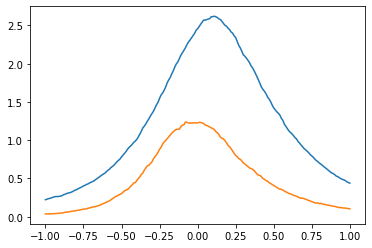

In [24]:
plt.plot(timeshift, baseMI)
plt.plot(timeshift, HC_MI)

# different Contrast

In [25]:
contrast_list = np.arange(0.01, 0.2, 0.02)
dC_Output_list = [f_E(eOutput*contrast, max(np.abs(eOutput)))*f_S(sOutput*contrast, max(np.abs(sOutput))) for contrast in contrast_list]

dC_MI = [0]*len(contrast_list)
for c in range(len(contrast_list)):
    rstate = SG(dC_Output_list[c], dt, 0, 10, 10)
    timeshift, dC_MI[c] = MIfunc(rstate, xstate, dt, window)

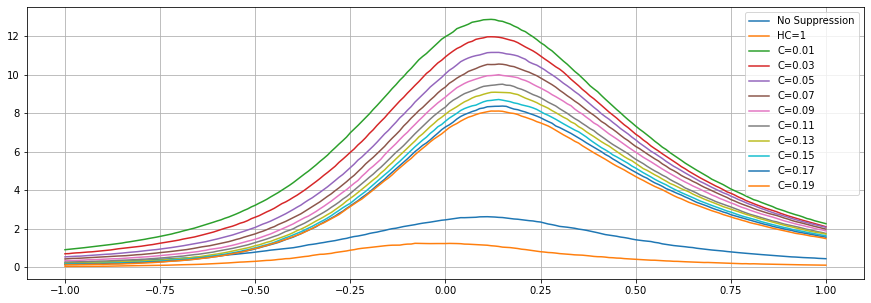

In [26]:
plt.plot(timeshift, baseMI, label='No Suppression')
plt.plot(timeshift, HC_MI, label='HC=1')
for c in range(len(contrast_list)):
    plt.plot(timeshift, dC_MI[c], label='C='+str(round(contrast_list[c],3)))
plt.legend(loc='best')
plt.grid()
plt.gcf().set_size_inches(15,5)

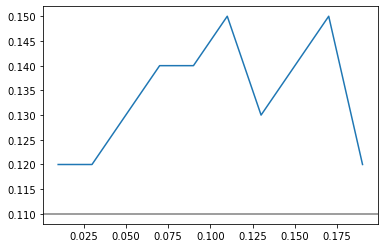

In [27]:
precede = [timeshift[np.argmax(MI)] for MI in dC_MI]

plt.plot(contrast_list, precede)
plt.axhline( timeshift[np.argmax(baseMI)], c ='gray' )